In [24]:
# All of your imports here (you may need to add some)
import numpy
import scipy
import pandas
from pandas import read_csv
import matplotlib.pylab as plt
import seaborn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

from sklearn import set_config
set_config(transform_output = "pandas")

# Project 2

It is October 2018. The squirrels in Central Park are running into a problem and we need your help.

For this project you must go through most steps in the checklist. You must write responses for all items however sometimes the item will simply be "does not apply". Some of the parts are a bit more nebulous and you simply show that you have done things in general (and the order doesn't really matter). Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Do not do the final part (launching the product) and your presentation will be done as information written in this document in a dedicated section, no slides or anything like that. It should however include the best summary plots/graphics/data points.

You are intentionally given very little information thus far. You must communicate with your client (me) for additional information as necessary. But also make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

You must submit all data files and a pickled preprocessor and final model along with this notebook.

Frame the Problem and Look at the Big Picture
=====================================
1. **Define the objective in business terms:** Help find the causes of the deaths of squirrels.
2. **How will your solution be used?** Used to manage or help prevent the spread or cause of deaths of squirrels.
3. **How should you frame this problem?** A classification problem that uses set parameters to determine if a squirrel will die or not.
4. **How should performance be measured? Is the performance measure aligned with the business objective?** Accuracy and f1 score so we can accurately predict positives and try and mitigate the false positives.
5. **What would be the minimum performance needed to reach the business objective?** Probably a f1 score in the 70 or 80 percent range.
6. **What are comparable problems? Can you reuse (personal or readily available) experience or tools?** None personal but probably some wildlife studies readily available online.
7. **Is human expertise available?** Some studies online by scientists focusing on urban animals.
8. **How would you solve the problem manually?** Find dead squirrels and try and find similar traits between them all and then compare to living squirrels and see if the traits we believe to cause the deaths is correct or not and reevaluate.
9. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** The data accurately can help track what causes deaths, fur color has an effect on deaths, and there are no seasonal or disease related effects that we know of.

# Get the Data

1. **List the data you need and how much you need:**
- Dead squirrels
- All squirrels seen and different traits and observations

2. **Find and document where you can get that data:** Some given and some found at https://data.cityofnewyork.us/Environment/2018-Central-Park-Squirrel-Census-Squirrel-Data/vfnx-vebw/about_data

3. **Get access authorizations**: None needed, publicy available.

4. **Create a workspace**: This notebook.
5. **Get the data**: Given to us and found online
6. **Convert the data to a format you can easily manipulate**: Done, they are all CSV's
7. **Ensure sensitive information is deleted or protected**: Done
8. **Check the size and type of data (time series, geographical, …)**: 3023 by 31 = 93,713. Float, objects, ints,  and booleans

Do not look at the data too closely at this point since you have not yet split off the testing set. Basically, enough looking at it to understand *how* to split the test set off. It is likely you will have to review the website where the data came from to be able to understand some of the features.

In [25]:
all_squirrels = read_csv('2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20241101.csv')
diseased_squirrels = read_csv('diseased_squirrels.csv')

In [26]:
diseased_squirrels_copy = diseased_squirrels.copy()
diseased_squirrels_copy['Diseased'] = 1
all_squirrels_copy = all_squirrels.copy()
# join the two dataframes together
squirrel_data = all_squirrels_copy.join(diseased_squirrels_copy.set_index('Unique Squirrel ID'), on='Unique Squirrel ID', how='left')

# if squirrels do not have a disease, they are not diseased
squirrel_data['Diseased'] = squirrel_data['Diseased'].fillna(0)



In [27]:
squirrel_data.head()


,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long,Diseased
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,False,False,False,False,False,False,False,NaN,POINT (-73.9561344937861 40.7940823884086),0.0
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,NaN,NaN,NaN,...,False,False,False,False,False,False,False,NaN,POINT (-73.9688574691102 40.7837825208444),0.0
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,False,False,False,False,False,False,False,NaN,POINT (-73.97428114848522 40.775533619083),0.0
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,False,False,False,False,False,False,True,NaN,POINT (-73.9596413903948 40.7903128889029),0.0
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,False,False,False,False,False,False,False,NaN,POINT (-73.9702676472613 40.7762126854894),0.0


- 'Lat/Long' is clearly not useful since there is the x and y coordinates

In [28]:
# replace Shift with is_PM_shift
squirrel_data['Shift'] = squirrel_data['Shift'].apply(lambda x: 1 if x == 'PM' else 0)
# replace Age with is_Adult
squirrel_data['Age'] = squirrel_data['Age'].apply(lambda x: 1 if x == 'Adult' else 0)
# replace false with 0 and true with 1 for the columns with boolean values
for comlumn in ['Running', 'Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks', 'Quaas', 'Moans', 'Tail flags', 'Tail twitches', 'Approaches', 'Indifferent', 'Runs from']:
    squirrel_data[comlumn] = squirrel_data[comlumn].apply(lambda x: 1 if x == True else 0)
# drop Lat/Long, Unique Squirrel ID, Other Interactions, Hectare, Age, Highlight Fur Color, Combination of Primary and Highlight Color, Color notes, Location, Specific Location, Above Ground Sighter Measurement
for column in ['Lat/Long', 'Unique Squirrel ID', 'Other Interactions', 'Hectare', 'Combination of Primary and Highlight Color', 'Color notes', 'Location', 'Specific Location', 'Above Ground Sighter Measurement']:
    squirrel_data.drop(column, axis=1, inplace=True)

# one hot encode Primary Fur Color and Highlight Fur Color
squirrel_data = pandas.get_dummies(squirrel_data, columns=['Primary Fur Color'])
squirrel_data = pandas.get_dummies(squirrel_data, columns=['Highlight Fur Color'])




squirrel_data.head()

,X,Y,Shift,Date,Hectare Squirrel Number,Age,Running,Chasing,Climbing,Eating,...,Highlight Fur Color_Black,"Highlight Fur Color_Black, Cinnamon","Highlight Fur Color_Black, Cinnamon, White","Highlight Fur Color_Black, White",Highlight Fur Color_Cinnamon,"Highlight Fur Color_Cinnamon, White",Highlight Fur Color_Gray,"Highlight Fur Color_Gray, Black","Highlight Fur Color_Gray, White",Highlight Fur Color_White
0,-73.956134,40.794082,1,10142018,3,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,-73.968857,40.783783,0,10192018,4,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,-73.974281,40.775534,1,10142018,8,0,0,1,0,0,...,False,False,False,False,False,False,False,False,False,False
3,-73.959641,40.790313,1,10172018,14,1,0,0,0,1,...,False,False,False,False,False,False,False,False,False,False
4,-73.970268,40.776213,0,10172018,5,1,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False


In [29]:
squirrel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3023 entries, 0 to 3022
Data columns (total 34 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   X                                           3023 non-null   float64
 1   Y                                           3023 non-null   float64
 2   Shift                                       3023 non-null   int64  
 3   Date                                        3023 non-null   int64  
 4   Hectare Squirrel Number                     3023 non-null   int64  
 5   Age                                         3023 non-null   int64  
 6   Running                                     3023 non-null   int64  
 7   Chasing                                     3023 non-null   int64  
 8   Climbing                                    3023 non-null   int64  
 9   Eating                                      3023 non-null   int64  
 10  Foraging    

In [30]:
squirrel_data.select_dtypes(include='bool').sum()


Primary Fur Color_Black                        103
Primary Fur Color_Cinnamon                     392
Primary Fur Color_Gray                        2473
Highlight Fur Color_Black                       34
Highlight Fur Color_Black, Cinnamon              9
Highlight Fur Color_Black, Cinnamon, White      32
Highlight Fur Color_Black, White                10
Highlight Fur Color_Cinnamon                   767
Highlight Fur Color_Cinnamon, White            268
Highlight Fur Color_Gray                       170
Highlight Fur Color_Gray, Black                  3
Highlight Fur Color_Gray, White                 59
Highlight Fur Color_White                      585
dtype: int64

In [31]:
squirrel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3023 entries, 0 to 3022
Data columns (total 34 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   X                                           3023 non-null   float64
 1   Y                                           3023 non-null   float64
 2   Shift                                       3023 non-null   int64  
 3   Date                                        3023 non-null   int64  
 4   Hectare Squirrel Number                     3023 non-null   int64  
 5   Age                                         3023 non-null   int64  
 6   Running                                     3023 non-null   int64  
 7   Chasing                                     3023 non-null   int64  
 8   Climbing                                    3023 non-null   int64  
 9   Eating                                      3023 non-null   int64  
 10  Foraging    

In [40]:
squirrel_data['Diseased'] = squirrel_data['Diseased'].astype('int64')

In [43]:
num_bool_cols = squirrel_data.select_dtypes(include=['float64', 'int64', 'bool']).columns
correlations = squirrel_data[num_bool_cols].corr()['Diseased'].sort_values(ascending=False)
correlations

Diseased                                      1.000000
Primary Fur Color_Cinnamon                    0.485947
Primary Fur Color_Black                       0.342990
Highlight Fur Color_Gray                      0.269459
Highlight Fur Color_Gray, White               0.207084
Approaches                                    0.073064
Age                                           0.064369
Highlight Fur Color_Gray, Black               0.057228
Hectare Squirrel Number                       0.050969
Highlight Fur Color_Black                     0.044521
Foraging                                      0.041118
Quaas                                         0.039298
Tail flags                                    0.026691
Moans                                         0.023173
Eating                                        0.022362
Highlight Fur Color_Black, White              0.017458
Date                                          0.015780
Kuks                                          0.012681
Tail twitc

Positive Correlation:

- Primary Fur Color (Cinnamon): Correlation of 0.49 suggests squirrels with a cinnamon fur color might be more prone to being diseased.
- Primary Fur Color (Black): Positive correlation of 0.34 indicates black-fur squirrels might also have a higher association with being diseased.
- Highlight Fur Color (Gray): Correlation of 0.27 could imply that gray-highlighted fur is more common among diseased squirrels.

Negative Correlation:

- Primary Fur Color (Gray): The strongest negative correlation (-0.58), suggesting that gray-fur squirrels are notably less likely to be diseased.
- Highlight Fur Color (Cinnamon) and Highlight Fur Color (Cinnamon, White): Negative correlations of -0.12 and -0.08, respectively, which might indicate that certain highlight colors are linked to lower disease rates.

Moderate Correlation:

- Approaches (0.073): Squirrels that approach humans might have a slight association with disease, potentially due to behavioral factors or exposure risks.
- Age (0.064): Mild positive correlation could imply age-related disease susceptibility.
- Spatial Coordinates (X and Y): Negative correlation with Y (-0.05) and X (-0.03), suggesting a possible spatial pattern but not too big of a correlation and graph seems to show it does not have an effect

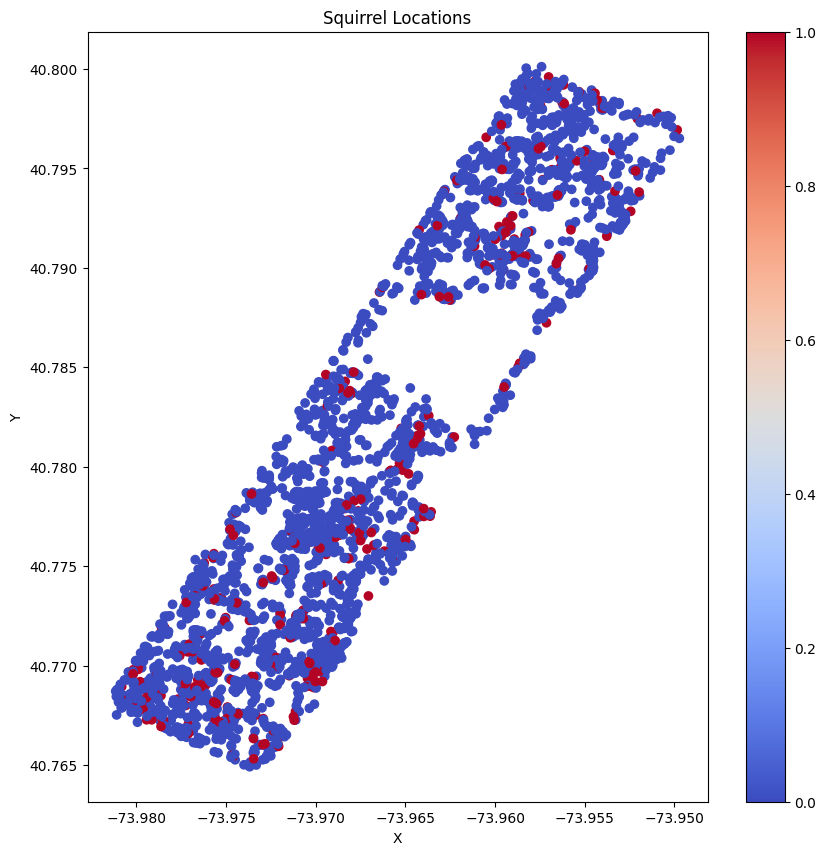

In [53]:
#Plot all squirrels and make the diseased squirrels stand out more and plot by X and Y coordinates
plt.figure(figsize=(10, 10))
plt.scatter(squirrel_data['X'], squirrel_data['Y'], c=squirrel_data['Diseased'], cmap='coolwarm')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Squirrel Locations')
plt.show()

In [48]:
# Step 1: Create a combined fur color feature
squirrel_data['Combined_Fur_Color'] = (
    squirrel_data['Primary Fur Color_Cinnamon'].astype(str) + '_' +
    squirrel_data['Primary Fur Color_Black'].astype(str) + '_' +
    squirrel_data['Highlight Fur Color_Gray'].astype(str) + '_' +
    squirrel_data['Highlight Fur Color_Gray, White'].astype(str)
)

# Step 2: Calculate the mean disease rate for each color combination
color_disease_rates = squirrel_data.groupby('Combined_Fur_Color')['Diseased'].mean()

# Display the results
print("Disease rates by fur color combination:")
print(color_disease_rates.sort_values(ascending=False))
squirrel_data.drop('Combined_Fur_Color', axis=1, inplace=True)

Disease rates by fur color combination:
Combined_Fur_Color
False_True_False_True      1.000000
False_True_False_False     0.670213
False_True_True_False      0.625000
True_False_False_True      0.551724
True_False_False_False     0.529070
True_False_True_False      0.438272
False_False_False_False    0.023339
Name: Diseased, dtype: float64


Highest Disease Rates:

- False_True_False_True and False_True_False_False: These combinations show the highest disease rates, with 100% and 67%, respectively. This suggests that squirrels with a black primary fur color (since the second entry is True) and varying combinations of highlight colors may be more prone to disease.
- False_True_True_False: With a disease rate of 62.5%, this combination further emphasizes that squirrels with black as their primary fur color might be at higher risk.

Gray Primary Fur Color (True for First Entry):

- True_False_False_True and True_False_False_False: Both combinations, where the primary color is gray, show moderate disease rates at 55% and 53%, suggesting some association with disease, though not as strong as for black fur color combinations.
- True_False_True_False: At 44%, this combination indicates that some gray-fur squirrels with a gray highlight color might still have an elevated disease rate, but to a lesser extent.

Lowest Disease Rate:

- False_False_False_False: This combination, representing squirrels with no cinnamon or black primary color and no gray or gray-white highlight colors, has a disease rate of just 2.3%. This may suggest that squirrels without these specific fur colors or combinations might generally have a lower disease risk.

In [9]:
# forest to find which features are important
y = squirrel_data['Diseased']
X = squirrel_data.drop('Diseased', axis=1)
# drop non-numeric columns, non-boolean columns
X = X.select_dtypes(include=['number', 'bool'])
# random forest classifier
forest = RandomForestClassifier()
forest.fit(X, y)
# get cross validation scores
acc = cross_val_score(forest, X, y, cv=10, scoring='accuracy').mean()
pre = cross_val_score(forest, X, y, cv=10, scoring='precision').mean()
rec = cross_val_score(forest, X, y, cv=10, scoring='recall').mean()
f1 = cross_val_score(forest, X, y, cv=10, scoring='f1').mean()
acc, pre, rec, f1




(np.float64(0.9229230870106878),
 np.float64(0.688834243774503),
 np.float64(0.5339962121212121),
 np.float64(0.6153619603167775))

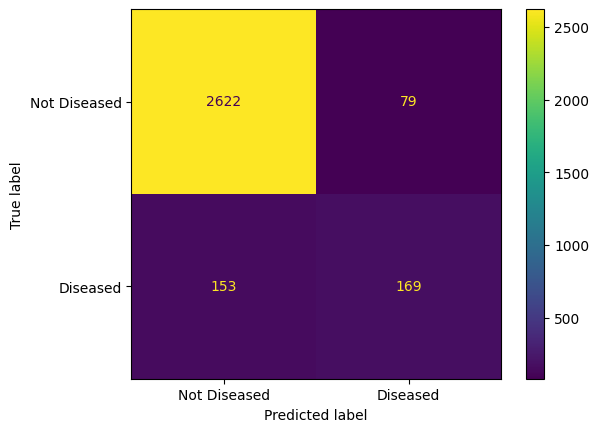

In [10]:
ConfusionMatrixDisplay(confusion_matrix(y, cross_val_predict(forest, X, y, cv=10)), display_labels=['Not Diseased', 'Diseased']).plot();

In [11]:
count = 1
for i in range(len(forest.feature_importances_)):
    if count < 2:
        print(f'{X.columns[i]}: {forest.feature_importances_[i].round(3)}', end='\t\t ')
        count += 1
    else:
        print(f'{X.columns[i]}: {forest.feature_importances_[i].round(3)}')
        count = 1

X: 0.11		 Y: 0.118
Shift: 0.021		 Date: 0.08
Hectare Squirrel Number: 0.069		 Age: 0.025
Running: 0.022		 Chasing: 0.007
Climbing: 0.021		 Eating: 0.018
Foraging: 0.02		 Kuks: 0.007
Quaas: 0.006		 Moans: 0.001
Tail flags: 0.008		 Tail twitches: 0.012
Approaches: 0.009		 Indifferent: 0.018
Runs from: 0.017		 Primary Fur Color_Black: 0.073
Primary Fur Color_Cinnamon: 0.118		 Primary Fur Color_Gray: 0.141
Highlight Fur Color_Black: 0.003		 Highlight Fur Color_Black, Cinnamon: 0.0
Highlight Fur Color_Black, Cinnamon, White: 0.002		 Highlight Fur Color_Black, White: 0.001
Highlight Fur Color_Cinnamon: 0.008		 Highlight Fur Color_Cinnamon, White: 0.005
Highlight Fur Color_Gray: 0.028		 Highlight Fur Color_Gray, Black: 0.001
Highlight Fur Color_Gray, White: 0.018		 Highlight Fur Color_White: 0.011


In [12]:
count = 1
for i in range(len(forest.feature_importances_)):
    if forest.feature_importances_[i] > .005:
        if count < 2:
            print(f'{X.columns[i]}: {forest.feature_importances_[i].round(3)}', end='\t\t ')
            count += 1
        else:
            print(f'{X.columns[i]}: {forest.feature_importances_[i].round(3)}')
            count = 1

X: 0.11		 Y: 0.118
Shift: 0.021		 Date: 0.08
Hectare Squirrel Number: 0.069		 Age: 0.025
Running: 0.022		 Chasing: 0.007
Climbing: 0.021		 Eating: 0.018
Foraging: 0.02		 Kuks: 0.007
Quaas: 0.006		 Tail flags: 0.008
Tail twitches: 0.012		 Approaches: 0.009
Indifferent: 0.018		 Runs from: 0.017
Primary Fur Color_Black: 0.073		 Primary Fur Color_Cinnamon: 0.118
Primary Fur Color_Gray: 0.141		 Highlight Fur Color_Cinnamon: 0.008
Highlight Fur Color_Gray: 0.028		 Highlight Fur Color_Gray, White: 0.018
Highlight Fur Color_White: 0.011		 

In [13]:
drops = []
for i in range(len(forest.feature_importances_)):
    if forest.feature_importances_[i] < .005:
        drops.append(X.columns[i])

In [14]:
# forest to find which features are important
y = squirrel_data['Diseased']
X = squirrel_data.drop('Diseased', axis=1)
X = X.drop(drops, axis=1)
# drop non-numeric columns, non-boolean columns
X = X.select_dtypes(include=['number', 'bool'])
# random forest classifier
forest = RandomForestClassifier()
forest.fit(X, y)
# get cross validation scores
acc = cross_val_score(forest, X, y, cv=10, scoring='accuracy').mean()
pre = cross_val_score(forest, X, y, cv=10, scoring='precision').mean()
rec = cross_val_score(forest, X, y, cv=10, scoring='recall').mean()
f1 = cross_val_score(forest, X, y, cv=10, scoring='f1').mean()
acc, pre, rec, f1


(np.float64(0.9255753721067471),
 np.float64(0.690883748885262),
 np.float64(0.5375),
 np.float64(0.5955490498459275))

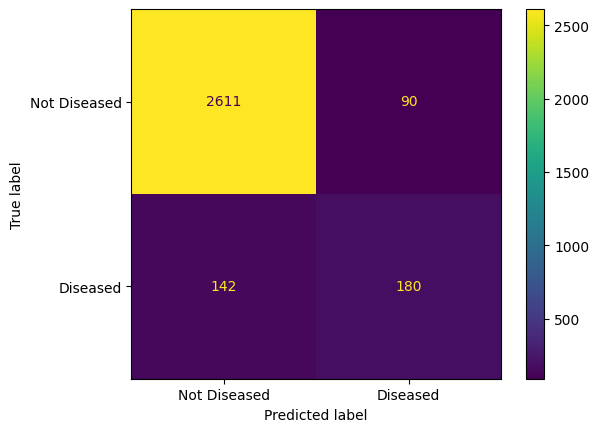

In [15]:
ConfusionMatrixDisplay(confusion_matrix(y, cross_val_predict(forest, X, y, cv=10)), display_labels=['Not Diseased', 'Diseased']).plot();